## **Preprocessing**
In this notebook we conduct EDA and preprocess the data to prepare it for the training and testing process

### **EDA**
**Goal**: understand the structure and content of the lyrics and MIDI files.


Lyrics:

    1. Distribution of song length (number of words per song).
    2. Distribution of unique words per song.
    3. Total number of words across all songs to understand the dataset's vocabulary size.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import pretty_midi
import csv

In [3]:
# Load the training and test set lyrics
lyrics_train_set_path = 'data/lyrics_train_set.csv'
lyrics_test_set_path = 'data/lyrics_test_set.csv'

lyrics_train_set = pd.read_csv(lyrics_train_set_path, header=None)
lyrics_test_set = pd.read_csv(lyrics_test_set_path, header=None)

# Combine the train and test set for a comprehensive analysis
lyrics_combined = pd.concat([lyrics_train_set, lyrics_test_set])

# Add column names
lyrics_combined.columns = ['artist', 'song', 'lyrics']
lyrics_combined.head()

,artist,song,lyrics
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...


In [4]:
# name columns
lyrics_train_set.columns = ['song', 'artist', 'lyrics']

<AxesSubplot: >

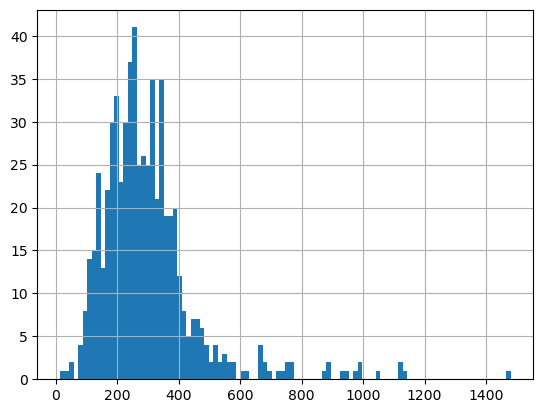

In [5]:
# plot the distribution of number of words in the lyrics
lyrics_train_set['lyrics'].str.split().str.len().hist(bins=100)


<AxesSubplot: >

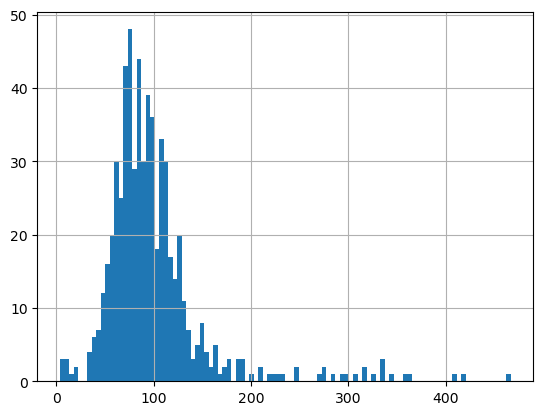

In [6]:
# plot the unique number of words in the lyrics
lyrics_train_set['lyrics'].str.split().apply(set).str.len().hist(bins=100)

<AxesSubplot: xlabel='word_count', ylabel='unique_word_count'>

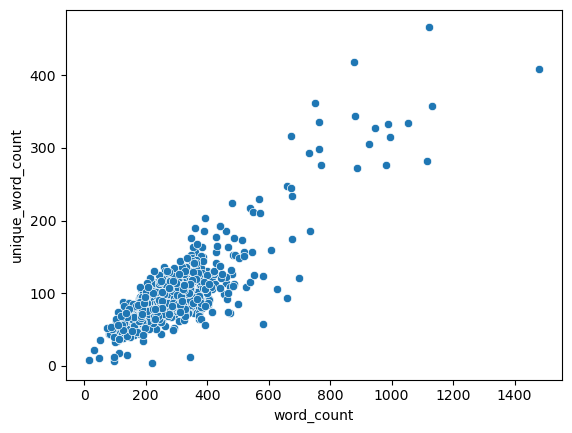

In [7]:
# visualize the relationship between the total word count and the unique word count per song, to see if longer songs necessarily use a more diverse vocabulary
lyrics_train_set['word_count'] = lyrics_train_set['lyrics'].str.split().str.len()
lyrics_train_set['unique_word_count'] = lyrics_train_set['lyrics'].str.split().apply(set).str.len()
sns.scatterplot(x='word_count', y='unique_word_count', data=lyrics_train_set)

In [8]:
import nltk

nltk.download('stopwords')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Function to calculate the frequency of stop words in lyrics
def stop_words_frequency(text):
    text_words = text.split()
    stop_words_in_text = [word for word in text_words if word.lower() in stop_words]
    return len(stop_words_in_text) / len(text_words) * 100  # Return percentage

lyrics_combined['stop_words_percentage'] = lyrics_combined['lyrics'].apply(stop_words_frequency)


In [10]:
from nltk.corpus import words
dictionary_words = set(words.words())

def dictionary_words_frequency(text):
    text_words = text.split()
    dictionary_words_in_text = [word for word in text_words if word.lower() in dictionary_words]
    return len(dictionary_words_in_text) / len(text_words) * 100  # Return percentage

lyrics_combined['dictionary_words_percentage'] = lyrics_combined['lyrics'].apply(dictionary_words_frequency)


In [11]:
def type_token_ratio(text):
    text_words = text.split()
    unique_words = set(text_words)
    return len(unique_words) / len(text_words) * 100  # Return percentage

lyrics_combined['TTR'] = lyrics_combined['lyrics'].apply(type_token_ratio)


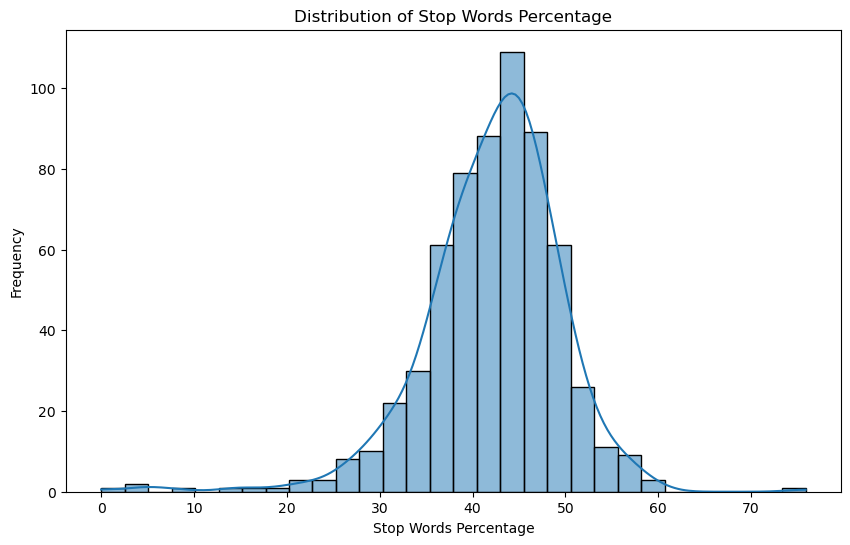

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plotting the distribution of stop words percentage
plt.figure(figsize=(10, 6))
sns.histplot(lyrics_combined['stop_words_percentage'], bins=30, kde=True)
plt.title('Distribution of Stop Words Percentage')
plt.xlabel('Stop Words Percentage')
plt.ylabel('Frequency')
plt.show()

# Similar plots can be made for dictionary words percentage and TTR


In [13]:
# get the total number of out of dictionary words in the lyrics
def ood_words_count(text):
    text_words = text.split()
    ood_words = [word for word in text_words if word.lower() not in dictionary_words]
    return len(ood_words)

lyrics_combined['ood_words_count'] = lyrics_combined['lyrics'].apply(ood_words_count)

In [14]:
# describe the dataset
lyrics_combined.describe()

,stop_words_percentage,dictionary_words_percentage,TTR,ood_words_count
count,620.000000,620.000000,620.000000,620.000000
mean,42.196860,73.374723,35.596268,79.595161
std,7.419227,7.060304,10.568010,49.928275
min,0.000000,0.000000,1.818182,6.000000
25%,38.488154,69.783612,28.069561,50.000000
50%,42.981899,74.168242,33.922988,69.000000
75%,46.737243,77.821830,42.131759,93.000000
max,75.882353,92.352941,70.400000,356.000000


#### MIDI files

In [105]:
import pretty_midi

In [106]:
# load a sample song
midi_data = pretty_midi.PrettyMIDI('data\midi_files\Cardigans_-_Lovefool.mid')

In [107]:
# Assuming we're focusing on the first instrument for simplicity
first_instrument = midi_data.instruments[0]
notes = [note.pitch for note in first_instrument.notes]

print(f"First 10 notes: {notes[:10]}")


First 10 notes: [42, 42, 46, 46, 42, 42, 46, 46, 42, 42]


In [108]:
tempo_changes = midi_data.get_tempo_changes()
initial_tempo = midi_data.estimate_tempo()

print(f"Initial estimated tempo: {initial_tempo} BPM")


Initial estimated tempo: 224.63110571874947 BPM


In [109]:
instrument_names = [instrument.program for instrument in midi_data.instruments if not instrument.is_drum]

print(f"Instrument programs: {instrument_names}")


Instrument programs: [26, 92, 38, 30, 4, 28, 27, 78]


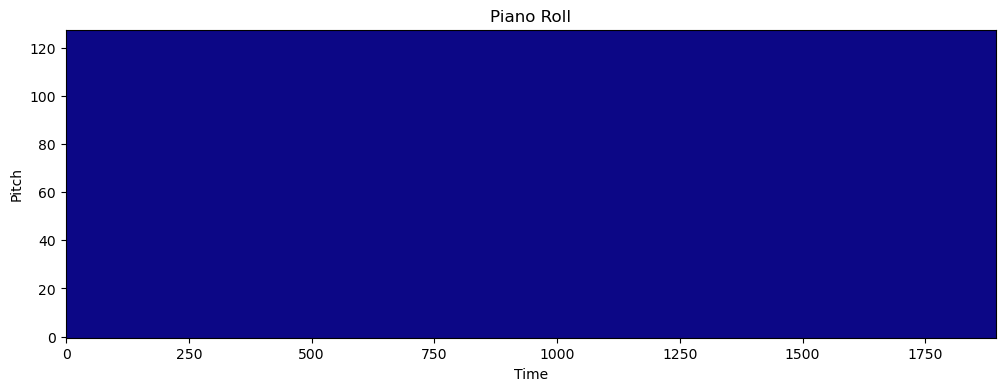

In [112]:
import matplotlib.pyplot as plt

# Generate a piano roll for the first instrument
piano_roll = first_instrument.get_piano_roll(fs=10)

plt.figure(figsize=(12, 4))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='plasma')
plt.title('Piano Roll')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.show()


In [113]:
# Function to extract the tempo, instrument programs and notes from a MIDI file
def extract_midi_features(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    # Tempo
    initial_tempo = midi_data.estimate_tempo()

    # Instrument programs
    instrument_programs = [instrument.program for instrument in midi_data.instruments if not instrument.is_drum]

    # Notes
    first_instrument = midi_data.instruments[0]
    notes = [note.pitch for note in first_instrument.notes]

    return initial_tempo, instrument_programs, notes


In [123]:
# create a df of tempo, instruments and notes from all files in midi_files
# get the list of all midi files
import os

midi_files_dir = 'data\midi_files'
midi_files = [os.path.join(midi_files_dir, file) for file in os.listdir(midi_files_dir) if file.endswith('.mid')]

# Create a dictionary to store the extracted features
midi_features = {
    'artist': [],
    'song': [],
    'tempo': [],
    'instruments': [],
    'notes': []
}

# Extract features from each MIDI file, splitting the name on "_-_" between artist and song
for file in midi_files:
    try:
        artist, song = os.path.basename(file).replace('.mid', '').split('_-_')
        tempo, instruments, notes = extract_midi_features(file)

        midi_features['artist'].append(artist)
        midi_features['song'].append(song)
        midi_features['tempo'].append(tempo)
        midi_features['instruments'].append(instruments)
        midi_features['notes'].append(notes)
    except(Exception) as e:
        print(f"Error processing file: {file}")
        print(f"Error: {e}")

# Create a DataFrame from the dictionary
midi_features_df = pd.DataFrame(midi_features)


c:\Users\Administrator\miniconda3\envs\nnenv\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file: data\midi_files\Aaron_Neville_-_Tell_It_Like_It_Is.mid
Error processing file: data\midi_files\Beastie_Boys_-_Girls.mid
Error processing file: data\midi_files\Billy_Joel_-_Movin'_Out.mid
Error processing file: data\midi_files\Billy_Joel_-_Pressure.mid
Error processing file: data\midi_files\Brian_McKnight_-_On_The_Down_Low.mid
Error processing file: data\midi_files\Dan_Fogelberg_-_Leader_of_the_Band.mid
Error processing file: data\midi_files\David_Bowie_-_Lazarus.mid
Error processing file: data\midi_files\Ed_Sheeran_-_Thinking_Out_Loud_-_Violin.mid
Error processing file: data\midi_files\Eric_Clapton_-_wonderful_tonight_-_live_extnd_version_@jiji@.mid


In [124]:
midi_features_df.head()

,artist,song,tempo,instruments,notes
0,1910_Fruitgum_Company,Simon_Says,259.928524,"[18, 34, 48, 67, 25, 0, 0, 61, 53, 16]","[61, 73, 85, 74, 62, 86, 66, 78, 90, 76, 64, 8..."
1,2_Unlimited,Get_Ready_for_This,257.189205,"[34, 33, 81, 19, 55, 48, 7, 127, 48, 25]","[28, 28, 23, 28, 21, 21, 23, 35, 28, 28, 23, 2..."
2,2_Unlimited,Let_the_Beat_Control_Your_Body,257.074121,"[53, 80, 39, 55, 85, 118, 38, 50, 48, 48]","[55, 55, 56, 55, 55, 55, 54, 53, 55, 55, 56, 5..."
3,2_Unlimited,Tribal_Dance,257.126357,"[65, 33, 38, 0, 52, 49, 29, 55, 47, 119]","[65, 48, 41, 53, 65, 48, 41, 53, 65, 48, 41, 5..."
4,2_Unlimited,Twilight_Zone,236.002360,"[90, 55, 82, 32, 103, 87, 118]","[78, 77, 78, 77, 78, 77, 78, 77, 78, 77, 78, 7..."


In [125]:
# artist and song to lowercase and replace "_" with " "
midi_features_df['artist'] = midi_features_df['artist'].str.lower().str.replace('_', ' ')
midi_features_df['song'] = midi_features_df['song'].str.lower().str.replace('_', ' ')


In [126]:
# Save the dataframe to a CSV file
midi_features_df.to_csv('data/midi_features.csv', index=False)

In [15]:
# load the midi features
midi_features_df = pd.read_csv('data/midi_features.csv')

<AxesSubplot: xlabel='instruments', ylabel='Count'>

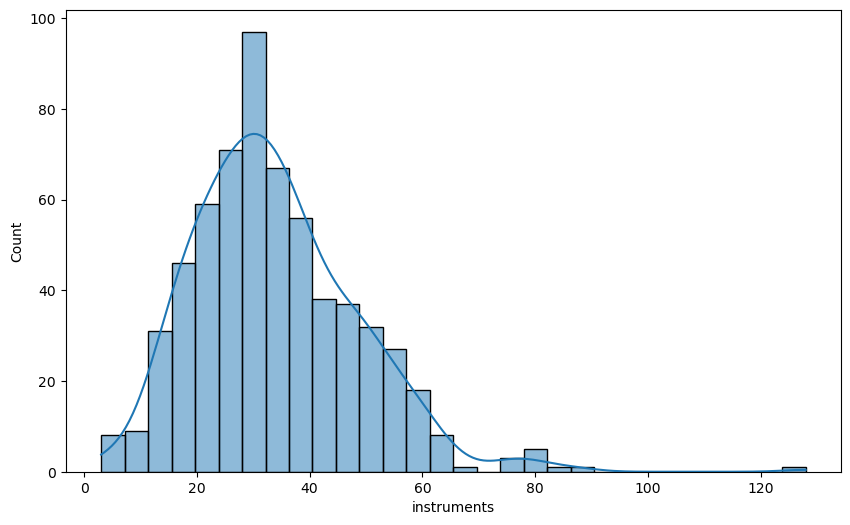

In [16]:
# how many instruments are used in the songs (distribution)
instruments = midi_features_df['instruments'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(instruments, bins=30, kde=True)

<AxesSubplot: xlabel='notes', ylabel='Count'>

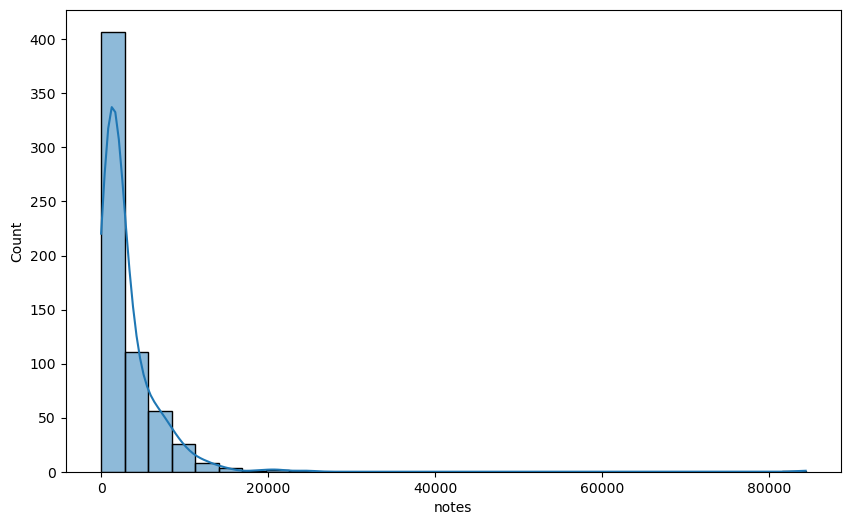

In [17]:
# how many notes are used in the songs (distribution)
notes = midi_features_df['notes'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(notes, bins=30, kde=True)

<AxesSubplot: xlabel='tempo', ylabel='Count'>

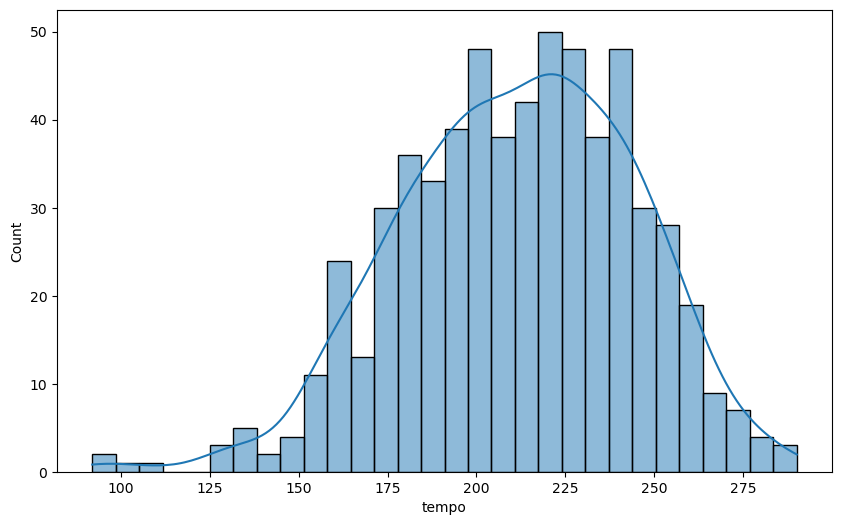

In [18]:
# what is the distribution of tempo in the songs
plt.figure(figsize=(10, 6))
sns.histplot(midi_features_df['tempo'], bins=30, kde=True)


In [22]:
# merge the lyrics and midi features
lyrics_midi = pd.merge(lyrics_combined, midi_features_df, on=['artist', 'song'], how='outer')

In [23]:
# analyze na's
lyrics_midi.isna().sum()

artist                          0
song                            0
lyrics                         13
stop_words_percentage          13
dictionary_words_percentage    13
TTR                            13
ood_words_count                13
tempo                          16
instruments                    16
notes                          16
dtype: int64

In [28]:
# drop na's
lyrics_midi = lyrics_midi.dropna()

# save the merged dataset
lyrics_midi.to_csv('data/lyrics_midi.csv', index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16060\2633969766.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(lyrics_midi.corr(), annot=True, cmap='coolwarm', fmt='.2f')


<AxesSubplot: >

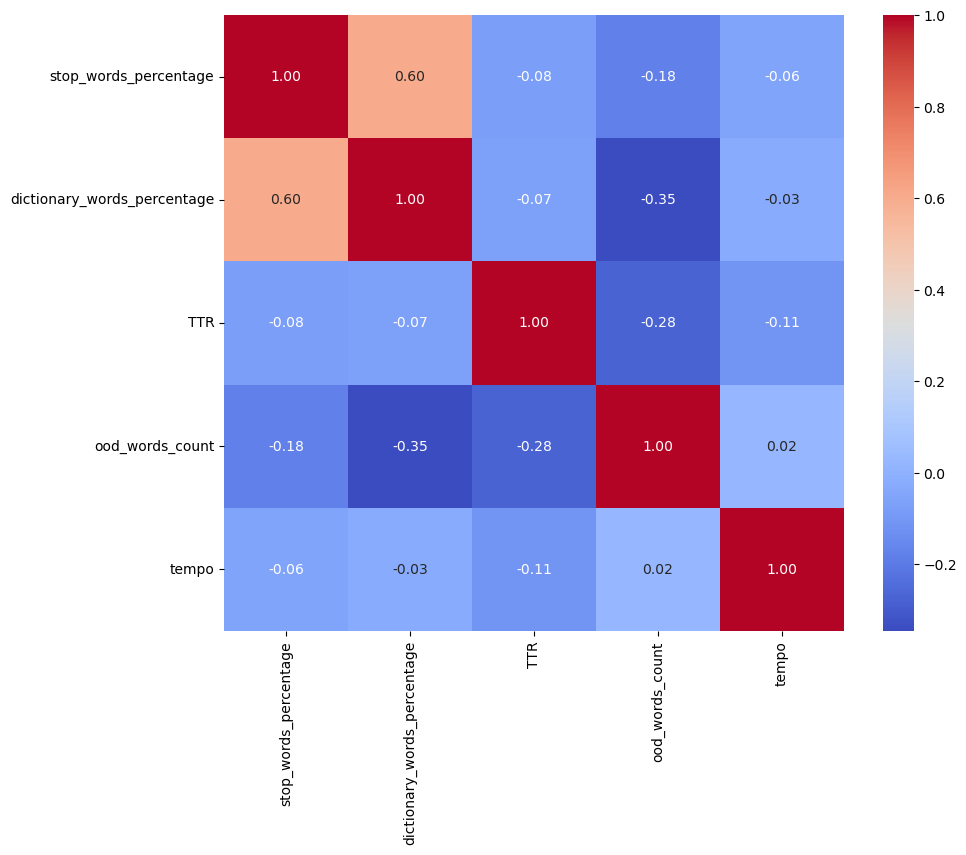

In [29]:
# heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lyrics_midi.corr(), annot=True, cmap='coolwarm', fmt='.2f')

#### Embeddings

In [35]:
# load the word2vec model
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric

In [33]:
# Load the pre-trained word2vec model i downloaded to models folder
word2vec_model_path = 'models/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [37]:
# for all words in dataset, check if they are in the word2vec model. print percentage of words in the model
lyrics_midi['lyrics'] = lyrics_midi['lyrics'].apply(remove_stopwords).apply(strip_punctuation).apply(strip_numeric)
lyrics_midi['lyrics'] = lyrics_midi['lyrics'].str.lower()

# Function to calculate the percentage of words in the word2vec model
def words_in_word2vec(text):
    words = text.split()
    words_in_model = [word for word in words if word in word2vec_model.index_to_key]
    return len(words_in_model) / len(words) * 100  # Return percentage

lyrics_midi['words_in_word2vec'] = lyrics_midi['lyrics'].apply(words_in_word2vec)

<AxesSubplot: xlabel='words_in_word2vec', ylabel='Count'>

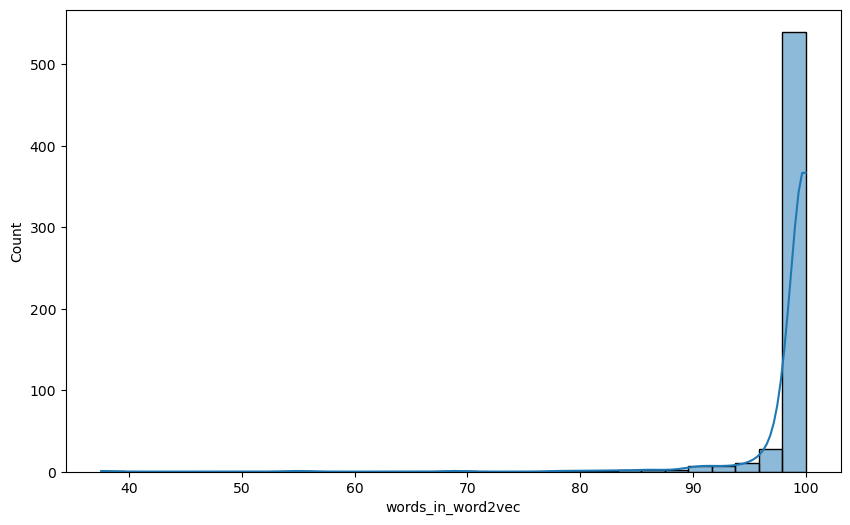

In [38]:
# plot the distribution of words in word2vec model
plt.figure(figsize=(10, 6))
sns.histplot(lyrics_midi['words_in_word2vec'], bins=30, kde=True)

In [39]:
# print the mean percentage of words in the word2vec model
lyrics_midi['words_in_word2vec'].mean()

98.93494175489215

In [47]:
# create a table for each column in the dataset, the column name, data type, the mean and the standard deviation (if numeric)
column_stats = []

for column in lyrics_midi.columns:
    column_type = lyrics_midi[column].dtype
    if column_type in [np.float64, np.int64]:
        column_mean = lyrics_midi[column].mean()
        column_std = lyrics_midi[column].std()
    else:
        column_mean = None
        column_std = None

    column_stats.append([column, column_type, column_mean, column_std])


column_stats_df = pd.DataFrame(column_stats, columns=['Column', 'Type', 'Mean', 'Std'])
column_stats_df

,Column,Type,Mean,Std
0,artist,object,NaN,NaN
1,song,object,NaN,NaN
2,lyrics,object,NaN,NaN
3,stop_words_percentage,float64,42.174596,7.453938
4,dictionary_words_percentage,float64,73.362243,7.061548
5,TTR,float64,35.440136,10.519813
6,ood_words_count,float64,80.013245,50.209047
7,tempo,float64,211.283381,32.768486
8,instruments,object,NaN,NaN
9,notes,object,NaN,NaN
